In [1]:
import sys
import cv2
import re
import csv

sys.path.append('..')

In [2]:
%matplotlib inline
import math as m
import numpy as np
from scipy import ndimage
from scipy.optimize import lsq_linear

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

from PIL import Image

from core import Core

from global_var import COLORS

In [3]:
matplotlib.rc('font', family='serif') 
matplotlib.rc('font', serif='Palatino Linotype') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 20})

In [4]:
folder = r'C:\SPRUP_data_Jenda\2022_07_19_UV\22_08_29/'.replace('\\', '/')

file = 'raw_13_1'


core = Core(folder, file)
core.type = 'int'
print(len(core))

366


In [5]:
mask = np.zeros(core.shape_img)

measurement = []

slices_x = []
slices_y = []
slices_ref = []

for j in range(4):
    k = 3 - j
    for i in range(3):
        dx = 40 + i * 217
        dy = 70 + k * 180
        sx = slice(dx, dx + 95)
        sy = slice(dy, dy + 95)
        slices_x.append(sx)
        slices_y.append(sy)
        
        measurement.append((i, j))
        mask[sx, sy] = 1
        
    dy = 70 + k * 180
    sr = slice(dy, dy + 95)

    slices_ref.append(sr)

masks_r = []
# for k in range(4):
#     mask_r = np.zeros(core.shape_img)
#     for i in range(4):
#         if i != k:
#             mask_r[:, slices_ref[i]] = 1
#     for j in range(3):    
#         masks_r.append(mask_r == 1)
for k in range(4):
    
    for i in range(3):  
        mask_r = np.zeros(core.shape_img)
        for j in range(4):
            if j != k:            
                dx = 40 + i * 217
                sx = slice(dx, dx + 95)
                mask_r[sx, slices_ref[j]] = 1
        masks_r.append(mask_r == 1)
            

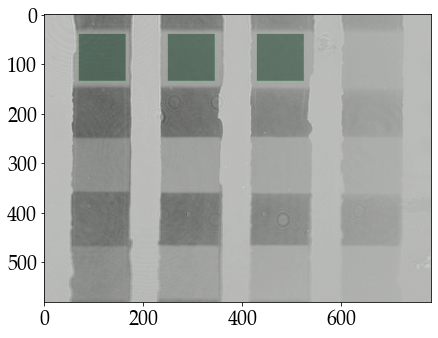

In [6]:
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1, 1])
# axes.set_title(file)
# axes.set_xlabel('frame')
# axes.set_ylabel('intensity [a. u.]')

core.ref_frame = 85
axes.imshow(
    core.frame(273),
    cmap='gray',
    zorder=0,
#     vmin=np.min(d)*0.2,
#     vmax=np.max(d)*0.2
)

# mask = np.zeros(core.shape_img)
# i = 5
# mask[:, slices_ref[0]] = 1

# mask[slices_x[6], slices_y[6]] = 1
mask = masks_r[0]

     
axes.imshow(
    mask,
    cmap='Greens',
    zorder=0,
    alpha = 0.3
#     vmin=np.min(d)*0.2,
#     vmax=np.max(d)*0.2
)

# fig.savefig(folder +'reference_01_ref2.png', dpi=300, bbox_inches='tight')   
# fig.savefig(folder +'area_all_02.png', dpi=300, bbox_inches='tight')    



In [19]:
doses = [56.8, 30.3, 14.9, 10.0, 5.0, 2.1]
doses_d =[]
for d in doses:
    doses_d.append(d)
    doses_d.append(d)
    
doses = np.array(doses)
doses_d = np.array(doses_d)


375
364
367
365
365
365
365
364
365
366
366
365


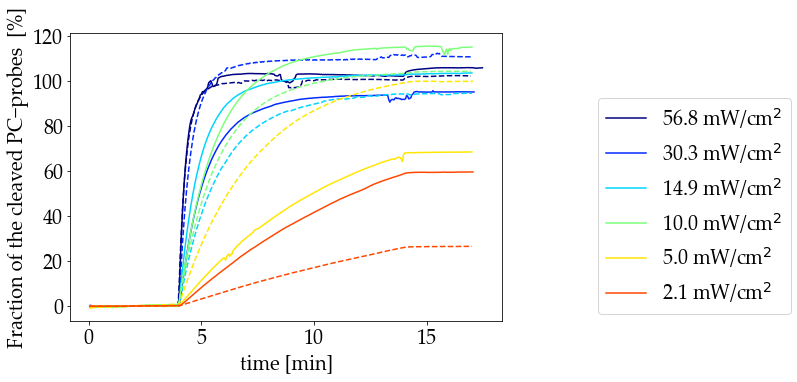

In [29]:
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1, 1])
# axes.set_title('Response of oligonucleotide to UV illumination')
# axes.set_suptitle('as')

axes.set_xlabel('time [min]')
axes.set_ylabel('Fraction of the cleaved PC−probes  [%]')

colors = pl.cm.jet(np.linspace(0,1,13))

responses = []

norm = [0.149]*3 + [0.139]*3 + [0.128]*3 + [0.112]*3

for i in range(1, 13):

    file = 'raw_{:02d}_1'.format(i)
    core = Core(folder, file)
    core.type = 'raw'
    print(len(core))
    
    time = np.array([i*2.8/60 for i in range(1, len(core))])


    spr = []
    for f in range(1, len(core)):
        spr.append(np.average(core.frame(f)[slices_x[i - 1], slices_y[i - 1]]))
    spr = np.array(spr)
    spr = spr / np.average(spr[:85]) * (-1)


    spr_ref = []
    for f in range(1, len(core)):
        spr_ref.append(np.average(core.frame(f)[masks_r[i - 1]]))
    spr_ref = np.array(spr_ref)
    spr_ref = spr_ref / np.average(spr_ref[:85]) * (-1)




    # axes.plot(spr)
    # axes.plot(spr_ref)
    signal = (spr - spr_ref)/norm[i-1] * 100
    
    if i%2 == 1:
        ls = '-'
        axes.plot(time, signal, label = '{} mW/cm$^2$'.format(doses_d[i - 1]), color=colors[(i - 1)//2*2], ls = ls)
    else:
        ls = '--'
        axes.plot(time, signal, color=colors[(i - 1)//2*2], ls = ls)
    
#     axes.plot(time, signal, label = '{} mW/cm$^2$'.format(doses_d[i - 1]), color=colors[(i - 1)//2*2], ls = ls)
    
    responses.append(np.average(signal[350:]))

lgd = fig.legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

fig.savefig(folder +'response_curves_ref2_norm.png', dpi=300, bbox_inches='tight')    



In [9]:
0%2

0

[104.058771372532, 102.92840647710827, 98.97526139891994, 109.57178660380282, 84.11176995454144, 43.01076254797343]
[1.762847429613302, 7.793611776898771, 4.463970004210722, 5.309800942218402, 15.71118213160537, 16.525543198710125]
[1.7628474296133092, 7.793611776898764, 4.463970004210729, 5.309800942218395, 15.711182131605362, 16.525543198710128]


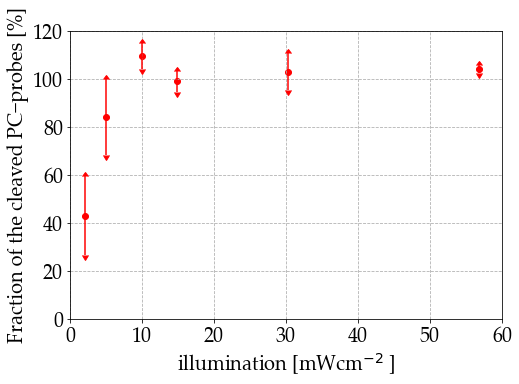

In [30]:



responses_avg =[]
weights = []
ebars = []

for i in range(len(doses)):
    responses_avg.append(np.average(responses[i*2:i*2+2]))
    ebars.append(np.max(responses[i*2:i*2+2]) - np.average(responses[i*2:i*2+2]))
    
    
    weights.append(np.std(responses[i*2:i*2+2]))
    
print(responses_avg)
print(ebars)
print(weights)



responses_avg = np.array(responses_avg)

p = np.polyfit(np.log(doses), responses_avg, 1)

a = p[0]
b = p[1]

doses_fitted = np.linspace(np.min(doses), np.max(doses), 100)
responses_fitted = np.log(np.exp(b)*doses_fitted**a)


    
    
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1, 1])
# axes.set_title('Response of oligonucleotide to UV illumination')
axes.set_xlabel('illumination [mWcm$^{-2}$ ]')
axes.set_ylabel('Fraction of the cleaved PC−probes [%]')
axes.set_xlim(0, 60)
axes.set_ylim(0, 120)
axes.grid(linestyle='--')


# axes.scatter(doses_d,responses, label = 'experimental data')

axes.errorbar(doses, responses_avg, weights, lolims=True,  fmt = 'none', color = 'r', label = 'average of ex. data')
axes.errorbar(doses, responses_avg, weights, uplims=True,  fmt = 'none', color = 'r', label = 'average of ex. data')

axes.scatter(doses, responses_avg, color = 'red', label = 'average of ex. data')



# textstr = 'fit by logarithmic function:\n$y = ln(bx^a)$\n$b = {:.5f}$, \n$a = {:.5}$'.format(np.exp(b), a)
# props = dict(boxstyle='square', facecolor='white', alpha=0.5)
# axes.text(0.5, 0.3, textstr, transform=axes.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)


# lgd = fig.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))


fig.savefig(folder +'response_fit_errorbars.png', dpi=300, bbox_inches='tight')    




In [18]:
print(doses/1e3)

[34.08 18.18  8.94  6.    3.    1.26]


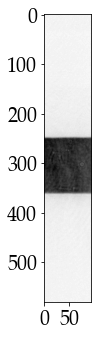

In [274]:
i = 8

file = 'raw_{:02d}_1'.format(i)
core = Core(folder, file)
core.ref_frame = 85

core.type = 'int'

mask = np.zeros(core.shape_img)
mask[:, slices_ref[0]] = 1

stripe = core.frame(350)[:, slices_ref[2]]


pilimage = Image.fromarray(stripe)


name = folder +'area_08'
pilimage.save(name + '.tiff', 'tiff')


fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1, 1])

axes.imshow(
    stripe,
    cmap='gray',
    zorder=0,
)

# axes.imshow(
#     mask,
#     cmap='Greens',
#     zorder=0,
#     alpha = 0.3
# #     vmin=np.min(d)*0.2,
# #     vmax=np.max(d)*0.2
# )

# fig.savefig(folder +'reference_01.png', dpi=300, bbox_inches='tight')   
fig.savefig(name +'.png', dpi=300, bbox_inches='tight')    

